##### **Enhancing Option Trading Predictions on Nifty-50 Using Ensemble Technique**

### **By :** Praveen Choudhary
### **Guid by :** Shail Sir

In [3]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    explained_variance_score, 
    r2_score, 
    mean_poisson_deviance, 
    mean_gamma_deviance, 
    accuracy_score
)

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Activation, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Other Libraries
import os
import math
import datetime as dt
import ta  # For technical analysis (if used in your project)
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [4]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [6]:
# # Read the CSV file
file_path = "/kaggle/input/dataset/NIFTY 50.csv"
df = pd.read_csv(file_path)

In [7]:
df.head(5)

,date,open,high,low,close,volume
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0


In [10]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.floor('5min')

df_resampled = df.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
})

In [11]:
df_resampled.head(5)

,open,high,low,close
date,,,,
2015-01-09 09:15:00,8285.45,8301.30,8285.45,8301.20
2015-01-09 09:20:00,8300.50,8303.00,8293.25,8301.00
2015-01-09 09:25:00,8301.65,8302.55,8286.80,8294.15
2015-01-09 09:30:00,8294.10,8295.75,8280.65,8288.50
2015-01-09 09:35:00,8289.10,8290.45,8278.00,8283.45


In [12]:
start = '2024-01-01'
end = '2024-01-10 10:45:00'

df = df_resampled.reset_index()
df = df[(df['date'] >= start) & (df['date'] <= end)]

In [13]:
len(df)

544

### **Create a signals On Original Data**

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
file_path = "/kaggle/input/dataset/NIFTY 50.csv"
df1 = pd.read_csv(file_path)

end = '2024-01-10 10:55:00'

# Convert the date column to datetime and floor it to 5 minutes
df1['date'] = pd.to_datetime(df1['date'])
df1['date'] = df1['date'].dt.floor('5min')

# Resample the data to get OHLC values
df_resampled1 = df1.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
}).dropna()

df_resampled1 = df_resampled1.reset_index()
df_resampled1 = df_resampled1[(df_resampled1['date'] >= start) & (df_resampled1['date'] <= end)]

# Calculate Moving Averages
df_resampled1['short_ma'] = df_resampled1['close'].rolling(window=5).mean()
df_resampled1['long_ma'] = df_resampled1['close'].rolling(window=20).mean()

# Calculate RSI
window_length = 14
delta = df_resampled1['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df_resampled1['rsi'] = 100 - (100 / (1 + rs))

# Calculate MACD
short_ema = df_resampled1['close'].ewm(span=12, adjust=False).mean()
long_ema = df_resampled1['close'].ewm(span=26, adjust=False).mean()
df_resampled1['macd'] = short_ema - long_ema
df_resampled1['macd_signal'] = df_resampled1['macd'].ewm(span=9, adjust=False).mean()

# Improved Signal Generation Logic
def generate_signal(row):
    # High priority: RSI thresholds for oversold/overbought conditions
    if row['rsi'] < 50:
        return 'sell'
    elif row['rsi'] > 50:
        return 'buy'
    
    # Medium priority: MACD crossovers for momentum detection
    if row['macd'] > row['macd_signal']:
        return 'buy'
    elif row['macd'] < row['macd_signal']:
        return 'sell'
    
    # Low priority: Moving average crossovers as a fallback
    if row['short_ma'] > row['long_ma']:
        return 'buy'
    else:
        return 'sell'

df_resampled1['signal'] = df_resampled1.apply(generate_signal, axis=1)

# Count the "buy" and "sell" signals only
signal_counts = df_resampled1['signal'].value_counts()
print(signal_counts)


signal
buy     275
sell    271
Name: count, dtype: int64


In [16]:
df_resampled1.tail(2)

,date,open,high,low,close,short_ma,long_ma,rsi,macd,macd_signal,signal
166485,2024-01-10 10:50:00,21516.7,21532.45,21515.15,21529.75,21536.63,21536.0100,42.729592,-13.780014,-16.628639,sell
166486,2024-01-10 10:55:00,21530.4,21536.85,21520.45,21525.60,21531.45,21534.6175,43.859649,-13.673273,-16.037566,sell


In [17]:
len(df)

544

In [18]:
len(df_resampled)

167366

In [19]:
df.tail()

,date,open,high,low,close
166480,2024-01-10 10:25:00,21534.85,21536.10,21523.40,21534.7
166481,2024-01-10 10:30:00,21535.30,21552.40,21534.05,21551.5
166482,2024-01-10 10:35:00,21550.75,21555.75,21542.80,21555.7
166483,2024-01-10 10:40:00,21555.80,21555.95,21525.60,21529.8
166484,2024-01-10 10:45:00,21529.25,21536.75,21512.10,21516.4


In [20]:
df_resampled = df.copy()

### **Create Bolinger Band**

In [21]:
import pandas as pd
# Define the window size for rolling calculations
window = 20  # Example window size, adjust as needed

# Calculate the moving average (Middle Band)
df_resampled['Middle Band'] = df_resampled['close'].rolling(window=window).mean()

# Calculate the rolling standard deviation
df_resampled['STD'] = df_resampled['close'].rolling(window=window).std()

# Calculate the Upper Band
df_resampled['Upper Band'] = df_resampled['Middle Band'] + (df_resampled['STD'] * 2)

# Calculate the Lower Band
df_resampled['Lower Band'] = df_resampled['Middle Band'] - (df_resampled['STD'] * 2)



In [22]:
# Drop rows with NaN values
df_resampled.dropna(inplace=True)

In [23]:
df1=df_resampled.reset_index()['close']
df7=df_resampled.reset_index()['Upper Band']
df8=df_resampled.reset_index()['Lower Band']

In [24]:
# deleting date column and normalizing using MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
del df_resampled['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(df_resampled).reshape(-1,1))
print(closedf.shape)

(4200, 1)


In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df7=scaler.fit_transform(np.array(df7).reshape(-1,1))
df8=scaler.fit_transform(np.array(df8).reshape(-1,1))

In [26]:
##splitting dataset into train and test split
##splitting dataset into train and test split
training_percentage = 0.65

training_size=int(len(df1)*training_percentage)
test_size=len(df1)-training_size

train_data_df1,test_data_df1=df1[0:training_size,:],df1[training_size:len(df1),:1]
train_data_df7,test_data_df7=df7[0:training_size,:],df7[training_size:len(df7),:1]
train_data_df8,test_data_df8=df8[0:training_size,:],df8[training_size:len(df8),:1]


In [27]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [28]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10

X_train_df1, y_train_df1 = create_dataset(train_data_df1, time_step)
X_test_df1, y_test_df1 = create_dataset(test_data_df1, time_step)

X_train_df7, y_train_df7 = create_dataset(train_data_df7, time_step)
X_test_df7, y_test_df7 = create_dataset(test_data_df7, time_step)

X_train_df8, y_train_df8 = create_dataset(train_data_df8, time_step)
X_test_df8, y_test_df8 = create_dataset(test_data_df8, time_step)

In [29]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train_df1 =X_train_df1.reshape(X_train_df1.shape[0],X_train_df1.shape[1] , 1)
X_test_df1 = X_test_df1.reshape(X_test_df1.shape[0],X_test_df1.shape[1] , 1)

X_train_df7 =X_train_df7.reshape(X_train_df7.shape[0],X_train_df7.shape[1] , 1)
X_test_df7 = X_test_df7.reshape(X_test_df7.shape[0],X_test_df7.shape[1] , 1)

X_train_df8 =X_train_df8.reshape(X_train_df8.shape[0],X_train_df8.shape[1] , 1)
X_test_df8 = X_test_df8.reshape(X_test_df8.shape[0],X_test_df8.shape[1] , 1)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense


# **GRU MODEL**

In [43]:
import time

# Start the timer
start_time = time.time()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Function to create and train the GRU model
def create_and_train_model(X_train, y_train, X_test, y_test, batch_size):
    # EarlyStopping Callback
    callback = EarlyStopping(
        monitor="val_loss",
        min_delta=0.000001,
        patience=10,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
    
    model = Sequential()
    model.add(GRU(256, input_shape=(time_step, 1), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(GRU(128))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Use 'relu' if needed
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    
#     model = Sequential()
#     model.add(GRU(128, input_shape=(time_step,1), return_sequences=True))
#     model.add(Dropout(0.1))
#     model.add(LSTM(128))
#     model.add(Dropout(0.1))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
    
#     model = Sequential()
#     model.add(LSTM(256, input_shape=(time_step, 1), return_sequences=True))
#     model.add(Dropout(0.1))
#     model.add(LSTM(128))
#     model.add(Dropout(0.1))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(1, activation='linear'))  # Use 'relu' if needed
#     model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

    history = model.fit(X_train, y_train, epochs=3000, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=[callback])
    return model, history

# Train model1
model1, history_1 = create_and_train_model(X_train_df1, y_train_df1, X_test_df1, y_test_df1, batch_size=64)

# Train model7
model7, history_7 = create_and_train_model(X_train_df7, y_train_df7, X_test_df7, y_test_df7, batch_size=64)

# Train model_8
model8, history_8 = create_and_train_model(X_train_df8, y_train_df8, X_test_df8, y_test_df8, batch_size=64)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.1424 - mae: 0.3144 - mse: 0.1424 - val_loss: 0.0255 - val_mae: 0.1451 - val_mse: 0.0255
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0149 - mae: 0.0997 - mse: 0.0149 - val_loss: 0.0100 - val_mae: 0.0800 - val_mse: 0.0100
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0090 - mae: 0.0750 - mse: 0.0090 - val_loss: 0.0126 - val_mae: 0.0932 - val_mse: 0.0126
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - mae: 0.0618 - mse: 0.0071 - val_loss: 0.0078 - val_mae: 0.0689 - val_mse: 0.0078
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - mae: 0.0593 - mse: 0.0060 - val_loss: 0.0088 - val_mae: 0.0718 - val_mse: 0.0088
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - mae: 0.0561 - mse: 0.0057 - val_loss: 0.0058 - val_mae: 0.0529 - val_mse: 0.0058
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - mae: 0.0454 - mse: 0.0038 - val_loss: 0.0057 

In [44]:
import numpy as np
def predict_future(test_data, time_step, n_steps, model, time_interval, total_time):
    lst_output = []
    i = 0

    x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    while i < total_time:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_steps, 1))

            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]

            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())

            lst_output.extend(yhat.tolist())

        i += time_interval  # Increment by the specified time interval

    return lst_output

def make_predictions_and_recommendation(model1, model7, model8, X_train, y_train, X_test, y_test, scaler, test_data, time_step, n_steps, time_interval, total_time):
    # Make predictions
    train_predict_df1 = model1.predict(X_train)
    test_predict_df1 = model1.predict(X_test)
    train_predict_df7 = model7.predict(X_train)
    test_predict_df7 = model7.predict(X_test)
    train_predict_df8 = model8.predict(X_train)
    test_predict_df8 = model8.predict(X_test)
    
    
        # Transform back to original form
    train_predict_df1 = scaler.inverse_transform(train_predict_df1)
    test_predict_df1 = scaler.inverse_transform(test_predict_df1)
    original_ytrain_df1 = scaler.inverse_transform(y_train_df1.reshape(-1,1))
    original_ytest_df1 = scaler.inverse_transform(y_test_df1.reshape(-1,1))

    train_predict_df7 = scaler.inverse_transform(train_predict_df7)
    test_predict_df7 = scaler.inverse_transform(test_predict_df7)
    original_ytrain_df7 = scaler.inverse_transform(y_train_df7.reshape(-1,1))
    original_ytest_df7 = scaler.inverse_transform(y_test_df7.reshape(-1,1))

    train_predict_df8 = scaler.inverse_transform(train_predict_df8)
    test_predict_df8 = scaler.inverse_transform(test_predict_df8)
    original_ytrain_df8 = scaler.inverse_transform(y_train_df8.reshape(-1,1))
    original_ytest_df8 = scaler.inverse_transform(y_test_df8.reshape(-1,1))
    
    
    # Predict future values for different datasets
    output_df1 = predict_future(test_data_df1, time_step, n_steps, model1, time_interval, total_time)
    output_df7 = predict_future(test_data_df7, time_step, n_steps, model7, time_interval, total_time)
    output_df8 = predict_future(test_data_df8, time_step, n_steps, model8, time_interval, total_time)

    # Transform future predictions back to original scale
    close = scaler.inverse_transform(np.array(output_df1).reshape(-1, 1))
    ub = scaler.inverse_transform(np.array(output_df7).reshape(-1, 1))
    lb = scaler.inverse_transform(np.array(output_df8).reshape(-1, 1))
    
    # Generate buy/sell/hold recommendation
    buy = 0
    sell = 0 
    hold = 0

    if np.mean(train_predict_df1[-20:]) <= close[1]:
        recommendation = 'Buy'
        buy = 1
    elif np.mean(train_predict_df1[-20:]) > close[1] and np.mean(train_predict_df1[-20:]) < close[1]:
        recommendation = 'Hold'
        hold = 1
    else:
        recommendation = 'Sell'
        sell = 1 
    
    print(f"Recommendation: {recommendation}")
    return recommendation, buy, sell, hold

# Assuming model and test_data_df1, test_data_df2 are defined elsewhere
time_step = 10
n_steps = time_step
time_interval = 5  # User-specified time interval in minutes
num_intervals = 2  # Number of predictions you want
# Total time for predictions
total_time = num_intervals * time_interval


# Example usage of the function
recommendation, buy, sell, hold = make_predictions_and_recommendation(
    model1, model7, model8,
    X_train_df1, y_train_df1, X_test_df1, y_test_df1,
    scaler, test_data_df1, time_step, n_steps,
    time_interval, total_time
)

print(f"Buy: {buy}, Sell: {sell}, Hold: {hold}")

# End the timer
end_time = time.time()

# Calculate the time taken in seconds
time_taken = end_time - start_time

# Convert time taken to minutes and seconds
minutes = int(time_taken // 60)
seconds = time_taken % 60

# Output the result and time taken
print(f"Time taken: {minutes}:{seconds:.2f} (min:sec)")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Recommendation: Sell
Buy: 0, Sell: 1, Hold: 0
Time taken: 2:46.97 (min:sec)


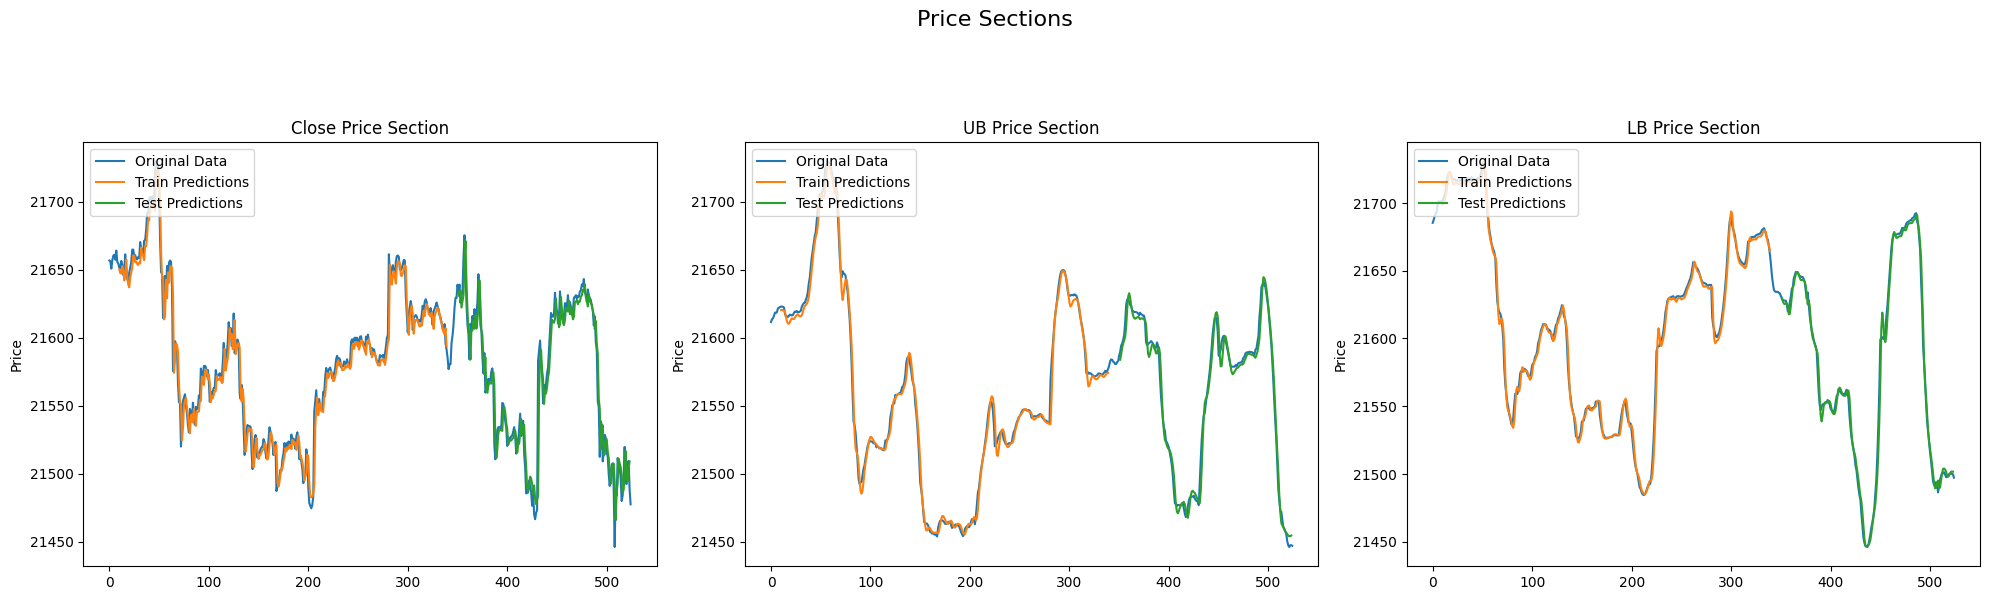

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_list, train_predict_list, and test_predict_list are lists of DataFrames and prediction arrays
# time_step should be defined appropriately
datasets = [
    ('Close Price Section', df1, train_predict_df1, test_predict_df1),
    ('UB Price Section', df7, train_predict_df7, test_predict_df7),
    ('LB Price Section', df8, train_predict_df8, test_predict_df8)
]

look_back = time_step  # Set your look_back or time_step value accordingly

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate over datasets and axes
for i, (title, df, train_predict, test_predict) in enumerate(datasets):
    # Initialize the train and test prediction plot arrays with NaN values
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

    # Plot the original data and the predictions on the current axis
    axes[i].plot(scaler.inverse_transform(df), label='Original Data')
    axes[i].plot(trainPredictPlot, label='Train Predictions')
    axes[i].plot(testPredictPlot, label='Test Predictions')

    # Set the title and labels
    axes[i].set_title(title)
    axes[i].set_ylabel('Price')
    axes[i].legend(loc='upper left')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add a main title
fig.suptitle('Price Sections', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the figure with all subplots
plt.show()


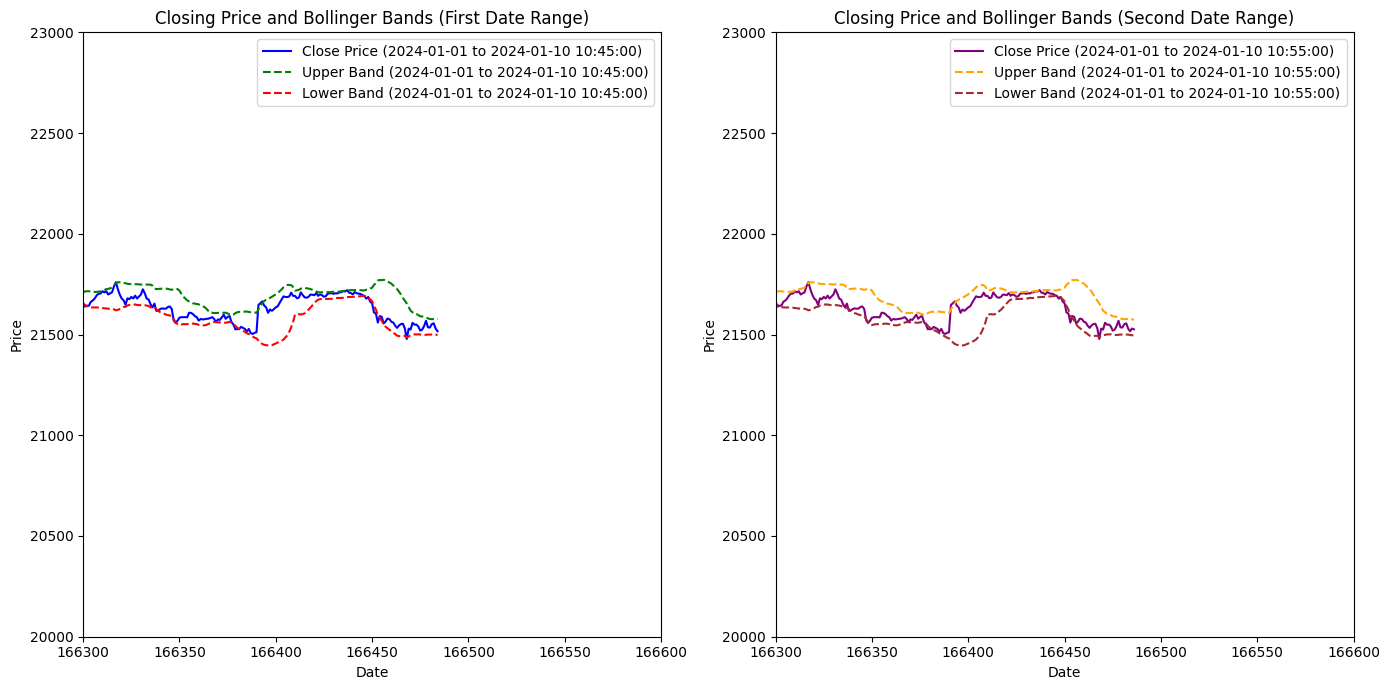

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the data
file_path = "/kaggle/input/dataset/NIFTY 50.csv"
df_2 = pd.read_csv(file_path)

# Process the date column
df_2['date'] = pd.to_datetime(df_2['date']).dt.floor('5min')

# Function to process data for a given date range
def process_data(df_2, start_date, end_date):
    # Resample the data
    df_resampled2 = df_2.groupby('date').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last'
    }).reset_index()

    # Filter by date range
    df_filtered2 = df_resampled2[(df_resampled2['date'] >= start_date) & (df_resampled2['date'] <= end_date)].copy()

    # Calculate the moving average and Bollinger Bands
    df_filtered2['Middle Band'] = df_filtered2['close'].rolling(window=20).mean()
    df_filtered2['STD'] = df_filtered2['close'].rolling(window=20).std()
    df_filtered2['Upper Band'] = df_filtered2['Middle Band'] + (df_filtered2['STD'] * 2)
    df_filtered2['Lower Band'] = df_filtered2['Middle Band'] - (df_filtered2['STD'] * 2)

    df_filtered2.dropna(inplace=True)
    
    return df_filtered2

# Date ranges for comparison
start_date_1 = start
end_date_1 = '2024-01-10 10:45:00'

start_date_2 = start
end_date_2 = end

# Process data for the first date range
df3 = process_data(df_2, start_date_1, end_date_1)

# Process data for the second date range
df2 = process_data(df_2, start_date_2, end_date_2)

# Plotting both charts side by side
plt.figure(figsize=(14, 7))

# First subplot for the first date range
plt.subplot(1, 2, 1)
plt.plot(df3['close'], label=f'Close Price ({start_date_1} to {end_date_1})', color='blue')
plt.plot(df3['Upper Band'], label=f'Upper Band ({start_date_1} to {end_date_1})', linestyle='--', color='green')
plt.plot(df3['Lower Band'], label=f'Lower Band ({start_date_1} to {end_date_1})', linestyle='--', color='red')
plt.title('Closing Price and Bollinger Bands (First Date Range)')
# Adding titles and labels
plt.xlim(166300,166600)
plt.ylim(20000,23000)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Second subplot for the second date range
plt.subplot(1, 2, 2)
plt.plot(df2['close'][:1481], label=f'Close Price ({start_date_2} to {end_date_2})', color='purple')
plt.plot(df2['Upper Band'][:1481], label=f'Upper Band ({start_date_2} to {end_date_2})', linestyle='--', color='orange')
plt.plot(df2['Lower Band'][:1481],label=f'Lower Band ({start_date_2} to {end_date_2})', linestyle='--', color='brown')
plt.title('Closing Price and Bollinger Bands (Second Date Range)')
plt.xlim(166300,166600)
plt.ylim(20000,23000)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()


In [46]:
print(len(df1))
print(len(df2))

525
527


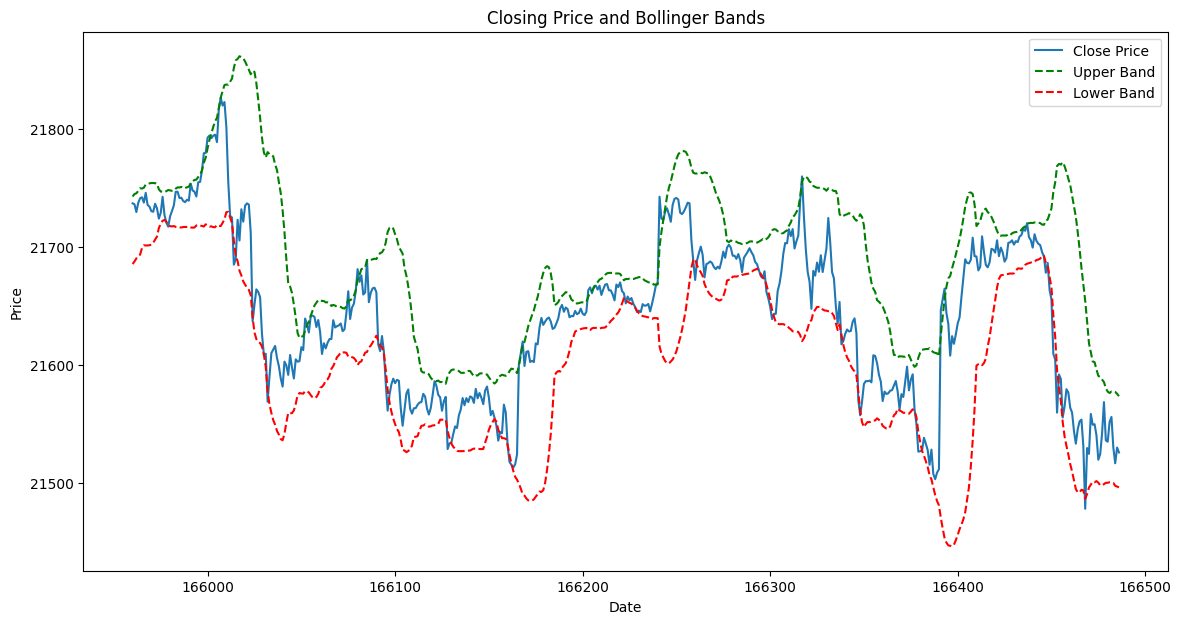

In [47]:
# Plotting the data
plt.figure(figsize=(14, 7))

# Plot the closing prices
plt.plot(df2['close'], label='Close Price')

# # Plot the upper and lower Bollinger Bands
plt.plot(df2['Upper Band'], label='Upper Band', linestyle='--',color='green')
plt.plot(df2['Lower Band'], label='Lower Band', linestyle='--', color='red')

# Adding titles and labels
plt.title('Closing Price and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [48]:
# Model summary
print(model1.summary())
print(model7.summary())
print(model8.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 10, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,893 (4.02 MB)

 Trainable params: 351,297 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 702,596 (2.68 MB)

None


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                    │ (None, 10, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,893 (4.02 MB)

 Trainable params: 351,297 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 702,596 (2.68 MB)

None


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                    │ (None, 10, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,893 (4.02 MB)

 Trainable params: 351,297 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 702,596 (2.68 MB)

None


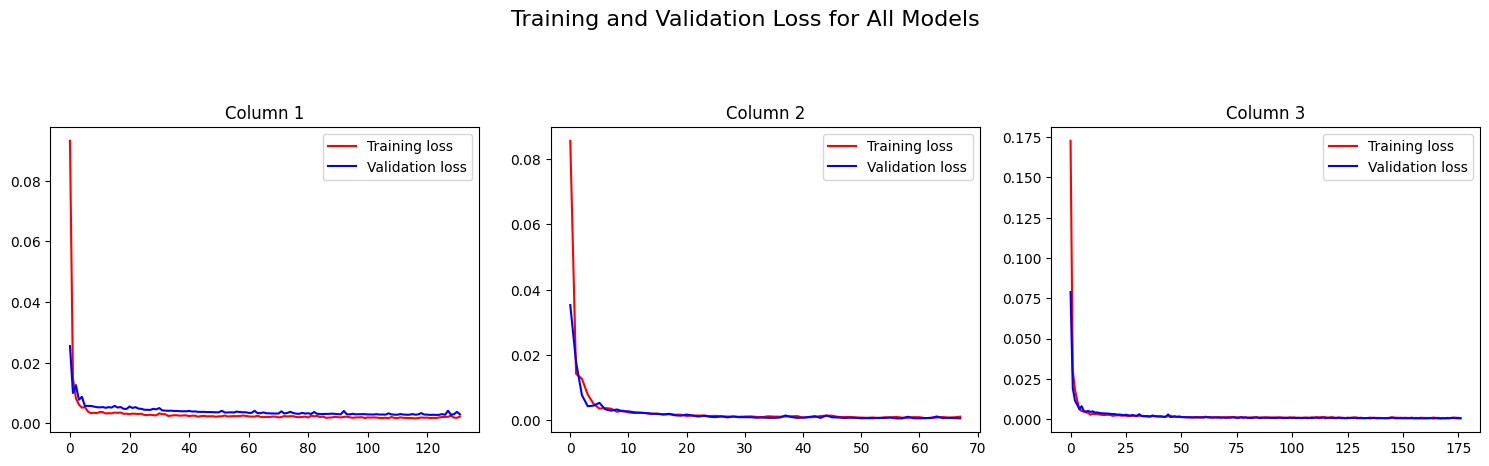

In [49]:
import matplotlib.pyplot as plt

# Assuming history_1 to history_8 are the history objects returned from model fitting
# histories = [history_1, history_2, history_3, history_4, history_5, history_6, history_7, history_8]
histories = [history_1, history_7, history_8]

# Set up the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each history object and corresponding axis
for i, history in enumerate(histories):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    axes[i].plot(epochs, loss, 'r', label='Training loss')
    axes[i].plot(epochs, val_loss, 'b', label='Validation loss')
    axes[i].set_title(f'Column {i+1}')
    axes[i].legend(loc='upper right')

# Hide any unused subplots (in case of different number of models)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Add a main title
fig.suptitle('Training and Validation Loss for All Models', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

#### **Next 5-min**

In [50]:
### Lets Do the prediction and check performance metrics
train_predict_df1=model1.predict(X_train_df1)
test_predict_df1=model1.predict(X_test_df1)

train_predict_df7=model7.predict(X_train_df7)
test_predict_df7=model7.predict(X_test_df7)

train_predict_df8=model8.predict(X_train_df8)
test_predict_df8=model8.predict(X_test_df8)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [51]:
# Transform back to original form
train_predict_df1 = scaler.inverse_transform(train_predict_df1)
test_predict_df1 = scaler.inverse_transform(test_predict_df1)
original_ytrain_df1 = scaler.inverse_transform(y_train_df1.reshape(-1,1))
original_ytest_df1 = scaler.inverse_transform(y_test_df1.reshape(-1,1))

train_predict_df7 = scaler.inverse_transform(train_predict_df7)
test_predict_df7 = scaler.inverse_transform(test_predict_df7)
original_ytrain_df7 = scaler.inverse_transform(y_train_df7.reshape(-1,1))
original_ytest_df7 = scaler.inverse_transform(y_test_df7.reshape(-1,1))

train_predict_df8 = scaler.inverse_transform(train_predict_df8)
test_predict_df8 = scaler.inverse_transform(test_predict_df8)
original_ytrain_df8 = scaler.inverse_transform(y_train_df8.reshape(-1,1))
original_ytest_df8 = scaler.inverse_transform(y_test_df8.reshape(-1,1))


In [52]:
from prettytable import PrettyTable
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function to calculate and return the metrics
def calculate_metrics(train_true, train_pred, test_true, test_pred):
    train_rmse = math.sqrt(mean_squared_error(train_true, train_pred))
    train_mse = mean_squared_error(train_true, train_pred)
    train_mae = mean_absolute_error(train_true, train_pred)

    test_rmse = math.sqrt(mean_squared_error(test_true, test_pred))
    test_mse = mean_squared_error(test_true, test_pred)
    test_mae = mean_absolute_error(test_true, test_pred)

    return train_rmse, train_mse, train_mae, test_rmse, test_mse, test_mae

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Category", "Data Type", "RMSE", "MSE", "MAE"]

# Add data to the table
categories = ["Close","UB", "LB"]

original_ytrain = [original_ytrain_df1, original_ytrain_df7, original_ytrain_df8]
original_ytest = [original_ytest_df1, original_ytest_df7, original_ytest_df8]
train_predict = [train_predict_df1,  train_predict_df7, train_predict_df8]
test_predict = [test_predict_df1,  test_predict_df7, test_predict_df8]


for i, category in enumerate(categories):
    train_rmse, train_mse, train_mae, test_rmse, test_mse, test_mae = calculate_metrics(original_ytrain[i], train_predict[i], original_ytest[i], test_predict[i])
    table.add_row([category, "Train", f"{train_rmse:.3f}", f"{train_mse:.3f}", f"{train_mae:.3f}"])
    table.add_row(["", "Test", f"{test_rmse:.3f}", f"{test_mse:.3f}", f"{test_mae:.3f}"])

# Print the table
print(table)


+----------+-----------+--------+---------+--------+
| Category | Data Type |  RMSE  |   MSE   |  MAE   |
+----------+-----------+--------+---------+--------+
|  Close   |   Train   | 10.973 | 120.416 | 7.481  |
|          |    Test   | 14.968 | 224.047 | 10.358 |
|    UB    |   Train   | 5.703  |  32.519 | 3.914  |
|          |    Test   | 6.750  |  45.569 | 5.115  |
|    LB    |   Train   | 4.705  |  22.133 | 3.311  |
|          |    Test   | 6.142  |  37.719 | 4.139  |
+----------+-----------+--------+---------+--------+


In [53]:
from sklearn.metrics import explained_variance_score

# Define a function to calculate and print the explained variance scores
def print_explained_variance(category, train_true, train_pred, test_true, test_pred):
    train_score = explained_variance_score(train_true, train_pred)
    test_score = explained_variance_score(test_true, test_pred)

    print(f"|   {category:8}  |   {train_score:.4f}    |   {test_score:.4f}   |")

# Print header
print("__________________________________________")
print("| Category    | Train Score | Test Score |")
print("|-------------|-------------|------------|")

# Call the function for each category
print_explained_variance("Close", original_ytrain_df1, train_predict_df1, original_ytest_df1, test_predict_df1)
print_explained_variance("UB", original_ytrain_df7, train_predict_df7, original_ytest_df7, test_predict_df7)
print_explained_variance("LB", original_ytrain_df8, train_predict_df8, original_ytest_df8, test_predict_df8)
print("*----------------------------------------*")

__________________________________________
| Category    | Train Score | Test Score |
|-------------|-------------|------------|
|   Close     |   0.9609    |   0.9261   |
|   UB        |   0.9939    |   0.9860   |
|   LB        |   0.9953    |   0.9929   |
*----------------------------------------*


In [54]:
from prettytable import PrettyTable
from sklearn.metrics import r2_score

# Original data for train and test sets
original_ytrain = [original_ytrain_df1, original_ytrain_df7, original_ytrain_df8]
original_ytest = [original_ytest_df1,  original_ytest_df7, original_ytest_df8]

# Predicted data for train and test sets
train_predict = [train_predict_df1, train_predict_df7, train_predict_df8]
test_predict = [test_predict_df1, test_predict_df7, test_predict_df8]

# Create a PrettyTable object
table = PrettyTable()

# Add column headers
table.field_names = ["Category", "Train R² Score", "Test R² Score"]

# Calculate and add rows
for i, category in enumerate(categories):
    train_r2 = r2_score(original_ytrain[i], train_predict[i])
    test_r2 = r2_score(original_ytest[i], test_predict[i])
    table.add_row([category, f"{train_r2:.4f}", f"{test_r2:.4f}"])

# Print the table
print(table)

+----------+----------------+---------------+
| Category | Train R² Score | Test R² Score |
+----------+----------------+---------------+
|  Close   |     0.9588     |     0.9260    |
|    UB    |     0.9935     |     0.9858    |
|    LB    |     0.9950     |     0.9929    |
+----------+----------------+---------------+


# **Next 10 Min Charts**

In [55]:
import numpy as np

# Assuming model and test_data_df1, test_data_df2 are defined elsewhere
time_step = 10
n_steps = time_step
time_interval = 5  # User-specified time interval in minutes
num_intervals = 2  # Number of predictions you want

# Total time for predictions
total_time = num_intervals * time_interval

def predict_future(test_data, time_step, n_steps, model, time_interval, total_time):
    lst_output = []
    i = 0

    x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    while i < total_time:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_steps, 1))

            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]

            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())

            lst_output.extend(yhat.tolist())

        i += time_interval  # Increment by the specified time interval

    return lst_output

# Predict future values for different datasets
output_df1 = predict_future(test_data_df1, time_step, n_steps, model1, time_interval, total_time)
print(f"Output of predicted next {total_time} minutes for df1: {len(output_df1)}")

output_df7 = predict_future(test_data_df7, time_step, n_steps, model7, time_interval, total_time)
print(f"Output of predicted next {total_time} minutes for df7: {len(output_df7)}")

output_df8 = predict_future(test_data_df8, time_step, n_steps, model8, time_interval, total_time)
print(f"Output of predicted next {total_time} minutes for df8: {len(output_df8)}")

Output of predicted next 10 minutes for df1: 2
Output of predicted next 10 minutes for df7: 2
Output of predicted next 10 minutes for df8: 2


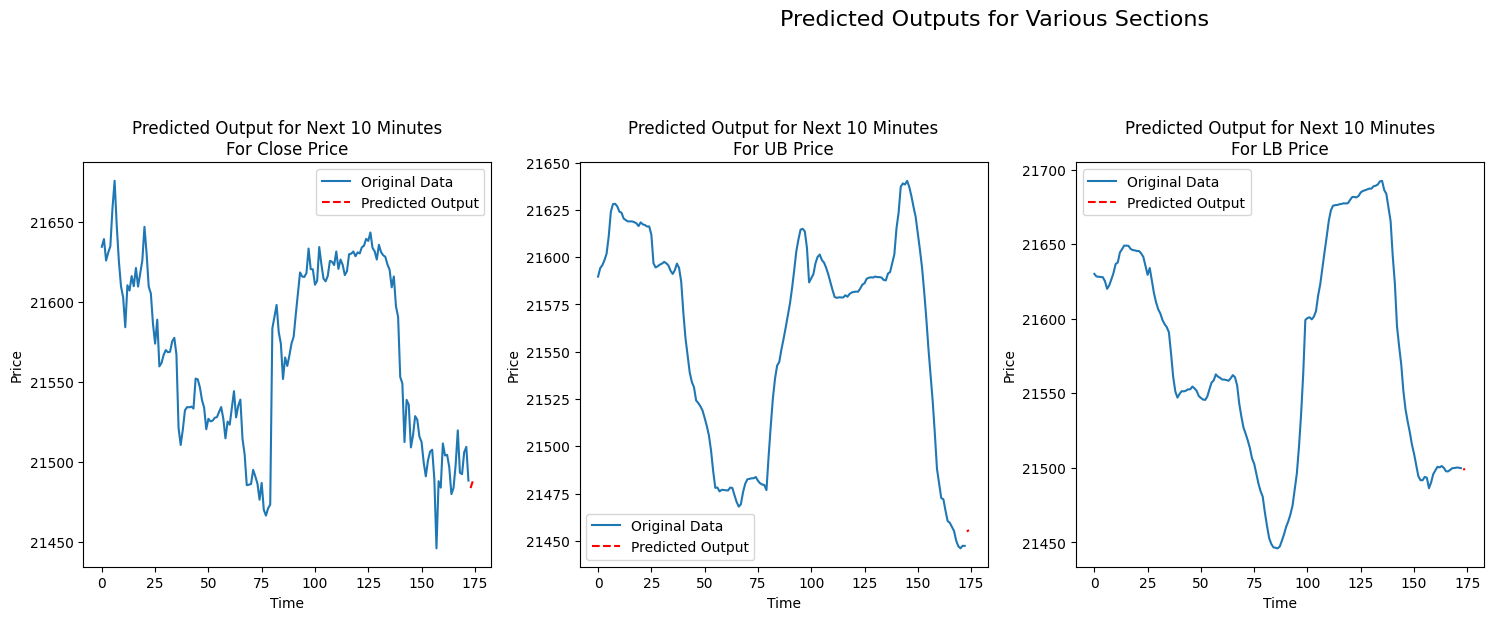

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming scaler, output_df1, output_df2, original_ytest_df1, original_ytest_df2, and total_time are defined

# List of tuples containing the data and titles for each plot
datasets = [
    ('Close Price', output_df1, original_ytest_df1),
    ('UB Price', output_df7, original_ytest_df7),
    ('LB Price', output_df8, original_ytest_df8)
]

def plot_predictions(predicted_output, original_data, title, ax):
    # Inverse transform the predicted output to get the original values
    predicted_output = scaler.inverse_transform(np.array(predicted_output).reshape(-1, 1))

    # Plot the original data and the predicted output
    ax.plot(original_data, label='Original Data')
    ax.plot(np.arange(len(original_data), len(original_data) + len(predicted_output)),
            predicted_output, label='Predicted Output', linestyle='--', color='red')
    ax.set_title(f"Predicted Output for Next {total_time} Minutes\nFor {title}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend()

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate over datasets and corresponding axes
for i, (title, predicted_output, original_data) in enumerate(datasets):
    plot_predictions(predicted_output, original_data, title, axes[i])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add a main title
fig.suptitle('Predicted Outputs for Various Sections', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the figure with all subplots
plt.show()


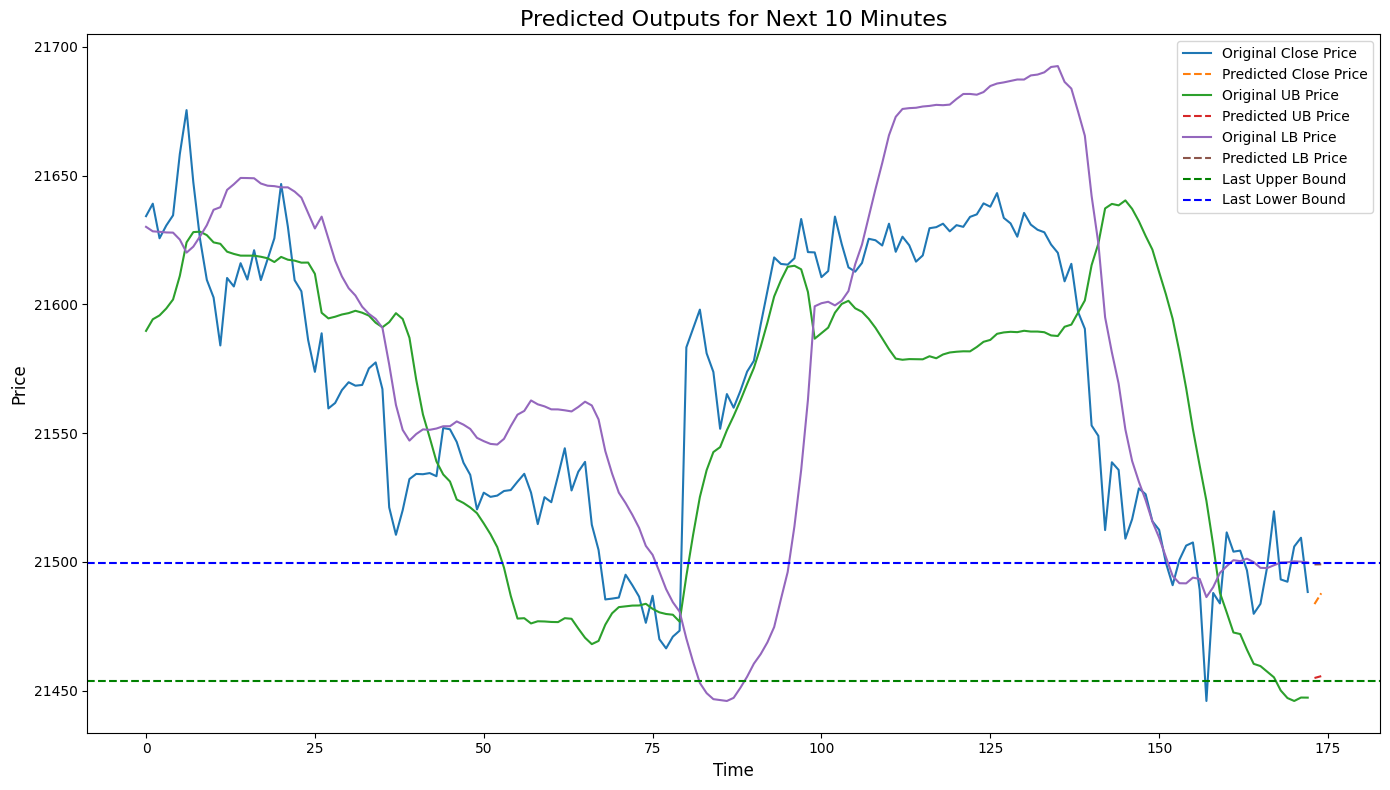

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming scaler, output_df1, output_df5, output_df7, output_df8, original_ytest_df1, original_ytest_df5, original_ytest_df7, original_ytest_df8, and total_time are defined

# List of tuples containing the data and titles for each plot
datasets = [
    ('Close Price', output_df1, original_ytest_df1),
    ('UB Price', output_df7, original_ytest_df7),
    ('LB Price', output_df8, original_ytest_df8)
]

def plot_predictions(predicted_output, original_data, title, ax):
    # Inverse transform the predicted output to get the original values
    predicted_output = scaler.inverse_transform(np.array(predicted_output).reshape(-1, 1))

    # Plot the original data and the predicted output
    ax.plot(original_data, label=f'Original {title}')
    ax.plot(np.arange(len(original_data), len(original_data) + len(predicted_output)),
            predicted_output, label=f'Predicted {title}', linestyle='--')

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(14, 8))

# Iterate over datasets and plot them on the same axes
for title, predicted_output, original_data in datasets:
    plot_predictions(predicted_output, original_data, title, ax)

# Add horizontal lines for the last UB and LB values
original_ub = np.mean(original_ytest_df7[-10:])
original_lb = np.mean(original_ytest_df8[-10:])
ax.axhline(y=original_ub, color='green', linestyle='--', label='Last Upper Bound')
ax.axhline(y=original_lb, color='blue', linestyle='--', label='Last Lower Bound')

# Set titles and labels
ax.set_title(f'Predicted Outputs for Next {total_time} Minutes', fontsize=16)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Price", fontsize=12)
ax.legend()

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()


In [58]:
close    = scaler.inverse_transform(np.array(output_df1).reshape(-1, 1))
ub       = scaler.inverse_transform(np.array(output_df7).reshape(-1, 1))
lb       = scaler.inverse_transform(np.array(output_df8).reshape(-1, 1))

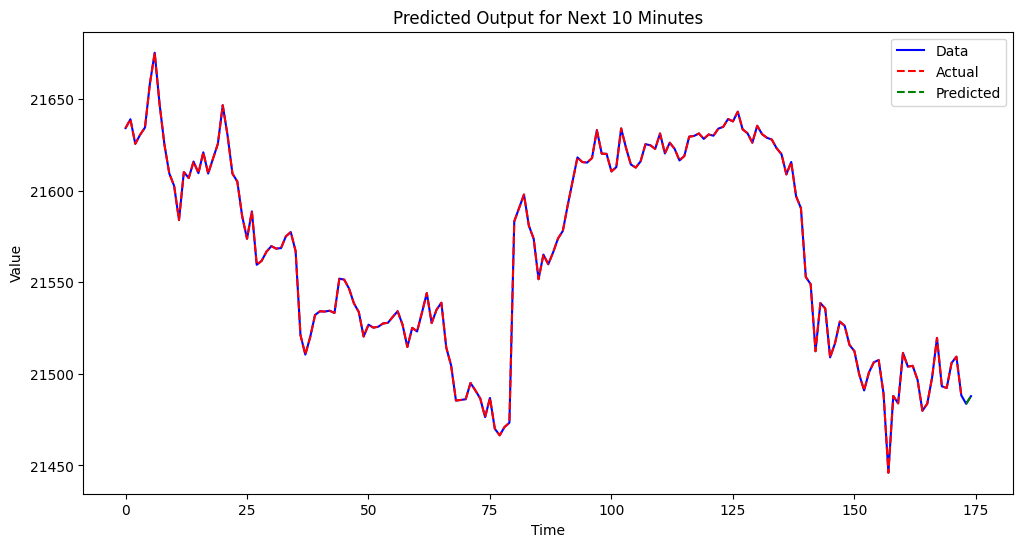

In [59]:
# Inverse transform the predicted output to get the original values
predicted_output = scaler.inverse_transform(np.array(output_df1).reshape(-1, 1))

# Plot the original data and the predicted output
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(np.concatenate((original_ytest_df1, predicted_output)), label='Data', color='blue')
plt.plot(original_ytest_df1, label='Actual', linestyle='--', color='red')
plt.plot(np.arange(len(original_ytest_df1), len(original_ytest_df1) + len(predicted_output)), predicted_output, label='Predicted', linestyle='--', color='green')
plt.legend()
plt.title(f"Predicted Output for Next {total_time} Minutes")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()